<a id="0"></a>
<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#1">Scraping wikipedia webpage to create a dataframe</a></li>
        <li><a href="#2">Appending latitude and longitude data to the table</a></li>
        <li><a href="#3">Clustering neighborhoods into borough using k-means</a></li>
    </ol>
</div>


<a id="1"></a>
## 1. Scraping wikipedia webpage to create a dataframe 

In [55]:
# import libraries 
import pandas as pd 
import numpy as np 
from IPython.display import Image 
from IPython.core.display import HTML
from googlemaps import Client as GoogleMaps 

In [56]:
# reading url using pandas
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
web = pd.read_html(url)

# converting list to dataframe 
df = web[0]
df

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
...,...,...,...
175,M5Z,Not assigned,NaN
176,M6Z,Not assigned,NaN
177,M7Z,Not assigned,NaN
178,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...


> Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [57]:
# filtering out rows with not assigned boroughs 
fil = (df['Borough'] == 'Not assigned')
df_fil1 = df[~fil]
df_fil1

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
...,...,...,...
160,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,Business reply mail Processing CentrE
169,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...


> More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

In [58]:
# using group by and join 
df_fil2 = df_fil1.groupby(['Postal code','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df_fil2['Neighborhood'] = [x.replace('/',',') for x in df_fil2['Neighborhood']]
df_fil2

,Postal code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern , Rouge"
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek"
2,M1E,Scarborough,"Guildwood , Morningside , West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov..."
101,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , Jam..."


> If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [59]:
df_fil2['Neighborhood'].replace('Not assigned',df_fil2['Borough'],inplace=True)
df_fil2

,Postal code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern , Rouge"
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek"
2,M1E,Scarborough,"Guildwood , Morningside , West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov..."
101,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , Jam..."


> In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [60]:
df_fil2.shape

(103, 3)

<a id="2"></a>
# 2. Appending latitude and longitude data to the table 

In [61]:
len(df_fil2)

103

In [62]:
# getting longitude and latitude data from google API 
import os
API = os.getenv('GMAP_API')
gmaps = GoogleMaps(API)

#create empty columns for latitude and longtitude 
df_fil2['Latitude'] = ''
df_fil2['Longitude'] = ''

# fetching latitude and longtitude data 
for x in range(len(df_fil2)):
    result = gmaps.geocode('{}, Toronto, Ontario'.format(df_fil2['Postal code'][x]))
    df_fil2['Latitude'][x] = result[0]['geometry']['location'] ['lat']
    df_fil2['Longitude'][x] = result[0]['geometry']['location']['lng']
    
df_fil2.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.8067,-79.1944
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.7845,-79.1605
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.7636,-79.1887
3,M1G,Scarborough,Woburn,43.771,-79.2169
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395


<a id="3"></a>
## 3. Clustering neighborhoods into borough using k-means 

In [63]:
# visualizing data points
import folium 

# setting central latitude and longitude 
latitude = 43.6532
longitude = -79.3832

# generate map centred around Toronto city
venues_map = folium.Map(location=[latitude, longitude], zoom_start=10) 

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_fil2['Latitude'], df_fil2['Longitude'], df_fil2['Neighborhood']):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map

In [64]:
# check the number of unique boroughs in toronto
len(df_fil2['Borough'].unique())

10

In [65]:
# import k-means & matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets import make_blobs

Text(0, 0.5, 'Longitude')

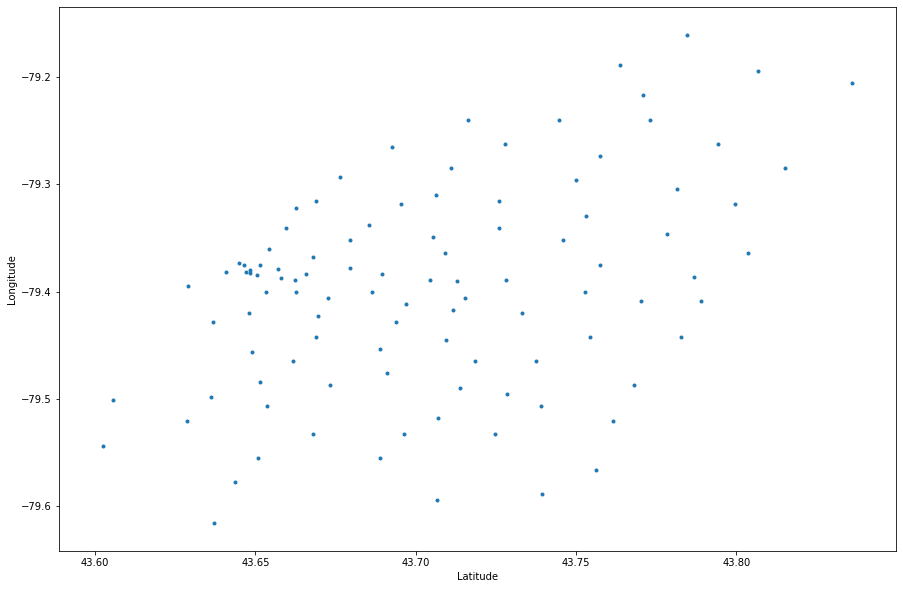

In [66]:
# plot out the latitude and longitude data points
plt.figure(figsize=(15, 10))
plt.scatter(df_fil2['Latitude'], df_fil2['Longitude'], marker='.')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [67]:
# throw latitude and longitude into feature set X 
X = df_fil2[['Latitude','Longitude']]

# set up k-means configuration
k_means = KMeans(init="k-means++", n_clusters=10, n_init=12) # n_init is the number of times the k-means algo is run with different centroid seeds
k_means.fit(X) # fit feature set X 

# getting the labels and cluster center coordinates
labels = k_means.labels_
cluster_centers = k_means.cluster_centers_

# add labels into original dataframe
df_fil2['Cluster'] = labels
df_fil2

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M1B,Scarborough,"Malvern , Rouge",43.8067,-79.1944,9
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.7845,-79.1605,9
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.7636,-79.1887,9
3,M1G,Scarborough,Woburn,43.771,-79.2169,9
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395,9
...,...,...,...,...,...,...
98,M9N,York,Weston,43.7069,-79.5182,7
99,M9P,Etobicoke,Westmount,43.6963,-79.5322,7
100,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov...",43.6889,-79.5547,4
101,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , Jam...",43.7394,-79.5884,4


In [68]:
# create a map to see if our clusters are appropriate 
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# import color libraries 
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
kclusters = 10
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, clu in zip(df_fil2['Latitude'], df_fil2['Longitude'], df_fil2['Borough'], df_fil2['Cluster']):
    label = folium.Tooltip(bor)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        tooltip=label,
        color=rainbow[clu-1],
        fill=True,
        fill_color=rainbow[clu-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the map above, we can see that we weren't able to segment the neighbourhoods into their respective boroughs accurately. Let's try to cluster the neighbourhoods based on geographical similarity and see if we can derive any additional insights. 

In [69]:
df_fil2['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
York                 5
East York            5
Mississauga          1
Name: Borough, dtype: int64

In [70]:
# filtering to toronto borough
df_toronto = df_fil2[df_fil2['Borough'].str.contains('Toronto')]
df_toronto

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster
37,M4E,East Toronto,The Beaches,43.6764,-79.293,1
41,M4K,East Toronto,"The Danforth West , Riverdale",43.6796,-79.3522,1
42,M4L,East Toronto,"India Bazaar , The Beaches West",43.669,-79.3156,1
43,M4M,East Toronto,Studio District,43.6595,-79.3409,1
44,M4N,Central Toronto,Lawrence Park,43.728,-79.3888,8
45,M4P,Central Toronto,Davisville North,43.7128,-79.3902,8
46,M4R,Central Toronto,North Toronto West,43.7154,-79.4057,8
47,M4S,Central Toronto,Davisville,43.7043,-79.3888,3
48,M4T,Central Toronto,"Moore Park , Summerhill East",43.6896,-79.3832,3
49,M4V,Central Toronto,"Summerhill West , Rathnelly , South Hill , For...",43.6864,-79.4,3


In [71]:
# getting downtown toronto coordinates
address = 'Downtown Toronto'
json_tor = gmaps.geocode(address)
latitude = json_tor[0]['geometry']['location']['lat']
longitude = json_tor[0]['geometry']['location']['lng']

In [72]:
# create map of downtown toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood']):
    label = folium.Tooltip(label, sticky=False)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [73]:
# settings and credentials 
LIMIT = 100
radius = 500
CLIENT_ID = os.getenv('4SQ_CLIENT_ID')
CLIENT_SECRET = os.getenv('4SQ_CLIENT_SECRET')
VERSION = 20200430 
borough_latitude = df_fil2.loc[0,'Latitude']
borough_longitude = df_fil2.loc[0,'Longitude']

# generating url 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)

# fetch data 
import requests
data = requests.get(url).json()

# assigning relevant part of JSON to venues 
venues = data['response']['groups'][0]['items']

# tranform venues into a dataframe
df_venue = pd.json_normalize(venues)
df_venue.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups
0,e-0-4bb6b9446edc76b0d771311c-0,0,"[{'summary': 'This spot is popular', 'type': '...",4bb6b9446edc76b0d771311c,Wendy’s,Morningside & Sheppard,43.807448,-79.199056,"[{'label': 'display', 'lat': 43.80744841934756...",387,CA,Toronto,ON,Canada,"[Toronto ON, Canada]","[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",0,[]


In [74]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in df_venue.columns if col.startswith('venue.location.')] + ['venue.id']
df_filtered = df_venue.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories'] #some places are named venue.categories instead of categories
        
    if len(categories_list) == 0: #some places don't have categories list 
        return None
    else:
        return categories_list[0]['name'] # the string we want to extract 

# filter the category for each row
df_filtered['venue.categories'] = df_filtered.apply(get_category_type, axis=1)

# clean columns
df_filtered.columns = [col.split('.')[-1] for col in df_filtered.columns]
df_filtered = df_filtered[['name','categories','lat','lng']]
df_filtered.head(10)

,name,categories,lat,lng
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056


Repeating the above step for each neighbourhood in downtown toronto.

In [75]:
# function to get nearby venues for each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try: 
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except: 
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [76]:
# getting nearby venues for neighbourhoods in toronto
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

The Beaches
The Danforth West , Riverdale
India Bazaar , The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park , Summerhill East
Summerhill West , Rathnelly , South Hill , Forest Hill SE , Deer Park
Rosedale
St. James Town , Cabbagetown
Church and Wellesley
Regent Park , Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond , Adelaide , King
Harbourfront East , Union Station , Toronto Islands
Toronto Dominion Centre , Design Exchange
Commerce Court , Victoria Hotel
Roselawn
Forest Hill North & West
The Annex , North Midtown , Yorkville
University of Toronto , Harbord
Kensington Market , Chinatown , Grange Park
CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport
Stn A PO Boxes
First Canadian Place , Underground city
Christie
Dufferin , Dovercourt Village
Little Portugal , Trinity
Brockton , Parkdale Village , Exhibition Place
High Park , 

In [77]:
# checking the dataframe returned
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop


In [78]:
# checking the venues returned for each neighborhood
toronto_venues['Neighborhood'].value_counts()

Toronto Dominion Centre , Design Exchange                                                                           100
Garden District, Ryerson                                                                                            100
First Canadian Place , Underground city                                                                             100
Harbourfront East , Union Station , Toronto Islands                                                                 100
Commerce Court , Victoria Hotel                                                                                     100
Richmond , Adelaide , King                                                                                           94
Stn A PO Boxes                                                                                                       93
Church and Wellesley                                                                                                 77
St. James Town                          

In [79]:
# number of unique categories 
len(toronto_venues['Venue Category'].unique())

228

In [80]:
# clustering based on types of venue category available in a neighborhood
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

# group by neighborhoods and taking mean
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [81]:
print (toronto_grouped.shape)
toronto_grouped.head()

(39, 228)


,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0
1,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Business reply mail Processing CentrE,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,"CN Tower , King and Spadina , Railway Lands , ...",0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Central Bay Street,0.016667,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.0


In [82]:
# function to get most common venues in a neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for i in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    except:
        columns.append('{}{}th Most Common Venue'.format(i+1,'th'))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]): #toronto_grouped.shape[0] returns the number of neighborhoods in toronto
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar
1,"Brockton , Parkdale Village , Exhibition Place",Nightclub,Café,Breakfast Spot
2,Business reply mail Processing CentrE,Park,Auto Workshop,Comic Shop
3,"CN Tower , King and Spadina , Railway Lands , ...",Airport Service,Airport Lounge,Airport Terminal
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place


In [83]:
kmeans.labels_[0:10].dtype 

dtype('int32')

In [84]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto.drop('Cluster', axis = 1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [85]:
toronto_merged.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
37,M4E,East Toronto,The Beaches,43.6764,-79.293,2,Health Food Store,Coffee Shop,Pub
41,M4K,East Toronto,"The Danforth West , Riverdale",43.6796,-79.3522,2,Greek Restaurant,Coffee Shop,Italian Restaurant
42,M4L,East Toronto,"India Bazaar , The Beaches West",43.669,-79.3156,2,Fast Food Restaurant,Park,Sandwich Place
43,M4M,East Toronto,Studio District,43.6595,-79.3409,2,Café,Coffee Shop,Bakery
44,M4N,Central Toronto,Lawrence Park,43.728,-79.3888,0,Swim School,Bus Line,Park


In [86]:
toronto_merged['Cluster Labels'].value_counts()

2    35
0     3
1     1
Name: Cluster Labels, dtype: int64

In [94]:
# create map of downtown toronto using latitude and longitude values
cluster_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)
    
# set color scheme for the clusters
kclusters = 3
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nei, clu in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Tooltip(nei)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        tooltip=label,
        color=rainbow[clu],
        fill=True,
        fill_color=rainbow[clu],
        fill_opacity=0.7).add_to(cluster_toronto)
    
cluster_toronto

### Cluster 1 - Outdoor Activities 

In [91]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
44,Central Toronto,0,Swim School,Bus Line,Park
50,Downtown Toronto,0,Park,Trail,Playground
64,Central Toronto,0,Park,Sushi Restaurant,Jewelry Store


### Cluster 2 - Family Time

In [92]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
48,Central Toronto,1,Playground,Women's Store,Dance Studio


### Cluster 3 - Foodies

In [93]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
37,East Toronto,2,Health Food Store,Coffee Shop,Pub
41,East Toronto,2,Greek Restaurant,Coffee Shop,Italian Restaurant
42,East Toronto,2,Fast Food Restaurant,Park,Sandwich Place
43,East Toronto,2,Café,Coffee Shop,Bakery
45,Central Toronto,2,Park,Convenience Store,Breakfast Spot
46,Central Toronto,2,Coffee Shop,Clothing Store,Yoga Studio
47,Central Toronto,2,Dessert Shop,Sandwich Place,Gym
49,Central Toronto,2,Coffee Shop,Pub,Fried Chicken Joint
51,Downtown Toronto,2,Coffee Shop,Restaurant,Bakery
52,Downtown Toronto,2,Coffee Shop,Sushi Restaurant,Japanese Restaurant


<a href="#0">Back to the top</a>